# Nonlinear regression using scipy or lmfit combined with using the delta-method to estimate confidence intervals and prediction intervals

**An example using a 4-parameter logistic function with a sigmoid shape**

by Greg Pelletier (gjpelletier@gmail.com)

This script uses the python package scipy or lmfit to find the optimum parameters and the variance-covariance of the parameters for nonlinear regression. We also include a new function using the delta-method, to extend beyond the capabilities of scipy or lmfit, to estimate confidence intervals for predicted values, and prediction intervals for new data, using the nonlinear regression fit.

The first step is to use scipy or lmfit to find the best-fit values and the variance-covariance matrix of the model parameters. The user may specify any expression for the nonlinear regression model.

The second step is to estimate the confidence intervals and prediction intervals using a new python function that applies the delta-method. The delta-method is described in detail in Section 5.1 of this online lecture:

https://jchiquet.github.io/MAP566/docs/regression/map566-lecture-nonlinear-regression.html#the-delta-method

In this example we use a 4-parameter logistic function with a sigmoid shape to fit an observed data set. The data set that we use provided by the R base package datasets, and consist of the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.

___

First we need to install lmfit if it is not already installed:


In [1]:
pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 5.6 MB/s eta 0:00:00


Next we import the necessary python packages:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
from numpy import exp, linspace, sin
import lmfit as fit
from lmfit.models import ExpressionModel
import scipy.optimize as opt

Next we will use an example provided by the R base package datasets, and consist of the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. In this example, x= duration of the eruption (minutes), and y= waiting time between eruptions (minutes).

In [3]:
x = np.array([3.6,1.8,3.333,2.283,4.533,2.883,4.7,3.6,1.95,4.35,1.833,3.917,
              4.2,1.75,4.7,2.167,1.75,4.8,1.6,4.25,1.8,1.75,3.45,3.067,4.533,3.6,1.967,
              4.083,3.85,4.433,4.3,4.467,3.367,4.033,3.833,2.017,1.867,4.833,1.833,4.783,
              4.35,1.883,4.567,1.75,4.533,3.317,3.833,2.1,4.633,2,4.8,4.716,1.833,4.833,
              1.733,4.883,3.717,1.667,4.567,4.317,2.233,4.5,1.75,4.8,1.817,4.4,4.167,4.7,
              2.067,4.7,4.033,1.967,4.5,4,1.983,5.067,2.017,4.567,3.883,3.6,4.133,4.333,
              4.1,2.633,4.067,4.933,3.95,4.517,2.167,4,2.2,4.333,1.867,4.817,1.833,4.3,
              4.667,3.75,1.867,4.9,2.483,4.367,2.1,4.5,4.05,1.867,4.7,1.783,4.85,3.683,
              4.733,2.3,4.9,4.417,1.7,4.633,2.317,4.6,1.817,4.417,2.617,4.067,4.25,1.967,
              4.6,3.767,1.917,4.5,2.267,4.65,1.867,4.167,2.8,4.333,1.833,4.383,1.883,4.933,
              2.033,3.733,4.233,2.233,4.533,4.817,4.333,1.983,4.633,2.017,5.1,1.8,5.033,
              4,2.4,4.6,3.567,4,4.5,4.083,1.8,3.967,2.2,4.15,2,3.833,3.5,4.583,2.367,5,
              1.933,4.617,1.917,2.083,4.583,3.333,4.167,4.333,4.5,2.417,4,4.167,1.883,
              4.583,4.25,3.767,2.033,4.433,4.083,1.833,4.417,2.183,4.8,1.833,4.8,4.1,
              3.966,4.233,3.5,4.366,2.25,4.667,2.1,4.35,4.133,1.867,4.6,1.783,4.367,
              3.85,1.933,4.5,2.383,4.7,1.867,3.833,3.417,4.233,2.4,4.8,2,4.15,1.867,
              4.267,1.75,4.483,4,4.117,4.083,4.267,3.917,4.55,4.083,2.417,4.183,2.217,
              4.45,1.883,1.85,4.283,3.95,2.333,4.15,2.35,4.933,2.9,4.583,3.833,2.083,
              4.367,2.133,4.35,2.2,4.45,3.567,4.5,4.15,3.817,3.917,4.45,2,4.283,4.767,
              4.533,1.85,4.25,1.983,2.25,4.75,4.117,2.15,4.417,1.817,4.467])
y = np.array([79,54,74,62,85,55,88,85,51,85,54,84,78,47,83,52,62,84,52,79,51,47,78,69,
              74,83,55,76,78,79,73,77,66,80,74,52,48,80,59,90,80,58,84,58,73,83,64,53,
              82,59,75,90,54,80,54,83,71,64,77,81,59,84,48,82,60,92,78,78,65,73,82,56,
              79,71,62,76,60,78,76,83,75,82,70,65,73,88,76,80,48,86,60,90,50,78,63,72,
              84,75,51,82,62,88,49,83,81,47,84,52,86,81,75,59,89,79,59,81,50,85,59,87,
              53,69,77,56,88,81,45,82,55,90,45,83,56,89,46,82,51,86,53,79,81,60,82,77,
              76,59,80,49,96,53,77,77,65,81,71,70,81,93,53,89,45,86,58,78,66,76,63,88,
              52,93,49,57,77,68,81,81,73,50,85,74,55,77,83,83,51,78,84,46,83,55,81,57,
              76,84,77,81,87,77,51,78,60,82,91,53,78,46,77,84,49,83,71,80,49,75,64,76,
              53,94,55,76,50,82,54,75,78,79,78,78,70,79,70,54,86,50,90,54,54,77,79,64,
              75,47,86,63,85,82,57,82,67,74,54,83,73,73,88,80,71,83,56,79,78,84,58,83,
              43,60,75,81,46,90,46,74])

_____
**Step 1: Using lmfit to find the optimum parameters and the variance-covarance matrix of the parameters**

Next we will use lmfit to find the optimum parameters (popt) and the variance-covariance matrix of the model parameters (pcov). Later we will show how to use scipy instead of lmfit for this step. The advantage of using lmfit is that it provides a concise report of many useful regression statistics.

We will use the ExpressionModel function of lmfit to specify the 4-parameter logistic function with a sigmoid shape that we want to fit to our data. ExpressionModel allows the user to define any function for the model as described at this link: https://lmfit.github.io/lmfit-py/builtin_models.html#user-defined-models

In [4]:
mod = ExpressionModel('(A-S) / ( 1 + exp(-gamma * (x - tau)) ) + S')

The next step is to define the initial values for the parameters of the model function. We will assume that the intial values for A=90, gamma=2, tau=2, S=50 as follows:

In [5]:
A_init = 90
gamma_init = 2
tau_init = 2
S_init = 50

Now we can build the set of the initial parameter values for input to lmfit as follows:

In [6]:
pars = fit.Parameters()
pars['A'] = fit.Parameter(name='A', value=A_init, min=-np.inf, max=np.inf)
pars['gamma'] = fit.Parameter(name='gamma', value=gamma_init, min=-np.inf, max=np.inf)
pars['tau'] = fit.Parameter(name='tau', value=tau_init, min=-np.inf, max=np.inf)
pars['S'] = fit.Parameter(name='S', value=S_init, min=-np.inf, max=np.inf)

Now we are ready to run lmfit to find the best-fit parameters and variance covariance matrix of the model. The output results will be stored in "out"

In [7]:
out = mod.fit(y, pars, x=x)

We can print out a summary of the model fit results from lmfit as follows:

In [8]:
print(out.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 272
    # variables        = 4
    chi-square         = 8469.42359
    reduced chi-square = 31.6023268
    Akaike info crit   = 943.249061
    Bayesian info crit = 957.672270
    R-squared          = 0.83090615
[[Variables]]
    A:      82.4660404 +/- 0.99770817 (1.21%) (init = 90)
    gamma:  2.25386376 +/- 0.43544396 (19.32%) (init = 2)
    tau:    3.05525924 +/- 0.11068420 (3.62%) (init = 2)
    S:      51.3218514 +/- 1.83125060 (3.57%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, S)   = +0.8634
    C(A, gamma)   = -0.7706
    C(tau, S)     = +0.7277
    C(A, S)       = -0.5381
    C(gamma, tau) = +0.4699


The optimum values of the model parameters (popt) from lmfit can now be extracted from the lmfit results as follows:

In [9]:
popt=np.array(out.params)
popt

array([82.46604039,  2.25386376,  3.05525924, 51.32185143])

The variance-covariance matrix of the model parameters (pcov) from lmfit can be extracted as follows:

In [10]:
pcov = out.covar
pcov

array([[ 9.95421585e-01, -3.34797388e-01,  2.19380329e-03,
        -9.83094996e-01],
       [-3.34797388e-01,  1.89611447e-01,  2.26490620e-02,
         6.88507824e-01],
       [ 2.19380329e-03,  2.26490620e-02,  1.22509924e-02,
         1.47504440e-01],
       [-9.83094996e-01,  6.88507824e-01,  1.47504440e-01,
         3.35347875e+00]])

_____
**Step 2: Using the delta-method to find the confidence intervals and prediction intervals**

Now we have almost everything we need in order to estimate the confidence intervals and prediction intervals of the model using the delta-method. Before doing that, we need to define a function that will apply the delta-method as follows:

In [11]:
def delta_method(pcov,popt,x_new,f,x,y,alpha):
    # - - -
    # Function to calculate the confidence interval and prediction interval
    # for any user-defined regression function using the delta-method
    # as described in Sec 5.1 of the following online statistics lecture:
    # https://jchiquet.github.io/MAP566/docs/regression/map566-lecture-nonlinear-regression.html
    #
    # Greg Pelletier (gjpelletier@gmail.com)
    # - - -
    # INPUT
    # pcov = variance-covariance matrix of the model parameters (e.g. from scipy or lmfit)
    # popt = optimum best-fit parameters of the regression function (e.g. from scipy or lmfit)
    # x_new = new x values to evaluate new predicted y_new values (e.g. x_new=linspace(min(x),max(x),100)
    # f = user-defined regression lambda function to predict y given inputs of parameters and x values (e.g. observed x or x_new)
    # 	For example, if using the 3-parameter nonlinear regression exponential threshold function, then
    # 	f = lambda param,xval : param[0] + param[1] * exp(param[2] * xval)
    # x = observed x
    # y = observed y
    # alpha = significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    # - - -
    # OUTPUT
    # dict = dictionary of output varlables with the following keys:
    #        'popt': optimum best-fit parameter values used as input
    #        'pcov': variance-covariance matrix used as input
    #        'fstr': string of the input lambda function of the regression model
    #        'alpha': input significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    #        'x': observed x values used as input
    #        'y': observed y values used as input
    #        'yhat': predicted y at observed x values
    #        'x_new': new x-values used as input to evaluate unew predicted y_new values
    #        'y_new': new predicted y_new values at new x_new values
    #        'lwr_conf': lower confidence interval for each value in x_new
    #        'upr_conf': upper confidence interval for each value in x_new
    #        'lwr_pred': lower prediction interval for each value in x_new
    #        'upr_pred': upper prediction interval for each value in x_new
    #        'grad_new': derivative gradients at x_new (change in f(x_new) per change in each popt)
    #        'G_new': variance due to each parameter at x_new
    #        'GS_new': variance due to all parameters combined at x_new
    #        'SST': Sum of Squares Total
    #        'SSR': Sum of Squares Regression
    #        'SSE': Sum of Squares Error
    #        'MSR': Mean Square Regression
    #        'MSE': Mean Square Error of the residuals
    #        'syx': standard error of the estimate
    #        'nobs': number of observations
    #        'nparam': number of parameters
    #        'df': degrees of freedom = nobs-nparam
    #        'qt': 2-tailed t-statistic at alpha
    #        'Fstat': F-statistic = MSR/MSE
    #        'dfn': degrees of freedom for the numerator of the F-test = nparam-1
    #        'dfd': degrees of freedom for the denominator of the F-test = nobs-nparam
    #        'pvalue': signficance level of the regression from the probability of the F-test
    #        'rsquared': r-squared = SSR/SST
    #        'adj_rsquared': adjusted squared
    import numpy as np
    from scipy import stats
    import inspect
    # - - -
    # calculate predicted y_new at each x_new
    y_new = f(popt,x_new)
    # calculate derivative gradients at x_new (change in f(x_new) per change in each popt)
    grad_new = np.empty(shape=(np.size(x_new),np.size(popt)))
    h = 1e-8       # h= small change for each popt to balance truncation error and rounding error of the gradient
    for i in range(np.size(popt)):
        # make a copy of popt
        popt2 = np.copy(popt)
        # gradient forward
        popt2[i] = (1+h) * popt[i]
        y_new2 = f(popt2, x_new)
        dy = y_new2 - y_new
        dpopt = popt2[i] - popt[i]
        grad_up = dy / dpopt
        # gradient backward
        popt2[i] = (1-h) * popt[i]
        y_new2 = f(popt2, x_new)
        dy = y_new2 - y_new
        dpopt = popt2[i] - popt[i]
        grad_dn = dy / dpopt
        # centered gradient is the average gradient forward and backward
        grad_new[:,i] = (grad_up + grad_dn) / 2
    # calculate variance in y_new due to each parameter and for all parameters combined
    G_new = np.matmul(grad_new,pcov) * grad_new         # variance in y_new due to each popt at each x_new
    GS_new = np.sum(G_new,axis=1)                       # total variance from all popt values at each x_new
    # - - -
    # # lwr_conf and upr_conf are confidence intervals of the best-fit curve
    nobs = np.size(x)
    nparam = np.size(popt)
    df = nobs - nparam
    qt = stats.t.ppf(1-alpha/2, df)
    delta_f = np.sqrt(GS_new) * qt
    lwr_conf = y_new - delta_f
    upr_conf = y_new + delta_f
    # - - -
    # # lwr_pred and upr_pred are prediction intervals of new observations
    yhat = f(popt,x)
    SSE = np.sum((y-yhat) ** 2)                 # sum of squares (residual error)
    MSE = SSE / df                              # mean square (residual error)
    syx = np.sqrt(MSE)                          # std error of the estimate
    delta_y = np.sqrt(GS_new + MSE) * qt
    lwr_pred = y_new - delta_y
    upr_pred = y_new + delta_y
    # - - -
    # optional additional outputs of regression statistics
    SST = np.sum(y **2) - np.sum(y) **2 / nobs  # sum of squares (total)
    SSR = SST - SSE                             # sum of squares (regression model)
    MSR = SSR / (np.size(popt)-1)              # mean square (regression model)
    Fstat = MSR / MSE           # F statistic
    dfn = np.size(popt) - 1    # df numerator = degrees of freedom for model = number of model parameters - 1
    dfd = df                    # df denomenator = degrees of freedom of the residual = df = nobs - nparam
    pvalue = 1-stats.f.cdf(Fstat, dfn, dfd)      # p-value of F test statistic
    rsquared = SSR / SST                                                        # ordinary rsquared
    adj_rsquared = 1-(1-rsquared)*(np.size(x)-1)/(np.size(x)-np.size(popt)-1)  # adjusted rsquared
    # - - -
    # make a string of the lambda function f to save in the output dictionary
    fstr = str(inspect.getsourcelines(f)[0])
    # make the dictionary of output variables from the delta-method
    dict = {
            'popt': popt,
            'pcov': pcov,
            'fstr': fstr,
            'alpha': alpha,
            'x': x,
            'y': y,
            'yhat': yhat,
            'x_new': x_new,
            'y_new': y_new,
            'lwr_conf': lwr_conf,
            'upr_conf': upr_conf,
            'lwr_pred': lwr_pred,
            'upr_pred': upr_pred,
            'grad_new': grad_new,
            'G_new': G_new,
            'GS_new': GS_new,
            'SST': SST,
            'SSR': SSR,
            'SSE': SSE,
            'MSR': MSR,
            'MSE': MSE,
            'syx': syx,
            'nobs': nobs,
            'nparam': nparam,
            'df': df,
            'qt': qt,
            'Fstat': Fstat,
            'dfn': dfn,
            'dfd': dfd,
            'pvalue': pvalue,
            'rsquared': rsquared,
            'adj_rsquared': adj_rsquared
            }

    return dict

Before using the delta_method function, we first need to make a few more inputs for it as follows (NOTE: make sure that the lambda function f below matches the ExpressionModel function defined above):

In [12]:
# model lambda function to use for any array of parameters (param) or x-values (xval)
f = lambda param,xval : (param[0]-param[3])/(1+exp(-param[1]*(xval-param[2])))+param[3]

# evenly spaced new observations that extend from below min(x) to above max(x)
x_new = linspace(1, 6, 100)

# probability level for the prediction limits (e.g. alpha=0.05 for 95% prediction limits and 95% confidence limits)
alpha=0.05

Now we are ready to use the delta_method function to get its outut dictionary, which includes the predicted y_new values, and the 95% prediction limits (lwr_pred and upr_pred), and 95% confidence limits (lwr_conf and upr_conf), at alpha=0.05 for new observations (x_new), as well as other regression statistics using the optimum parameters (popt) and covariance matrix (pcov)

In [13]:
d = delta_method(pcov,popt,x_new,f,x,y,alpha)

Now we can plot the results of the delta_method function to estimate the prediction intervals and confidence intervals.

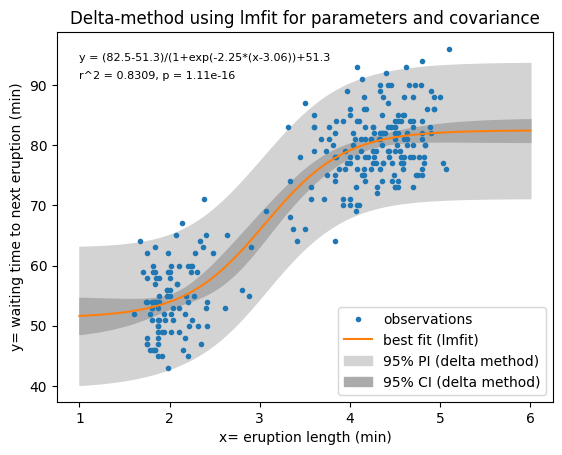

In [14]:
# extract the output values we need for the plot from the delta-method output dictionary
y_new = d['y_new']
lwr_conf = d['lwr_conf']
upr_conf = d['upr_conf']
lwr_pred = d['lwr_pred']
upr_pred = d['upr_pred']
rsquared = d['rsquared']
pvalue = d['pvalue']

# make string values of fit stats and eqn for the plot labels
pstr = '%.2e' %pvalue
rsqstr = '%.4f' %rsquared
b1str = '%.1f' %popt[0]
b2str = '%.2f' %popt[1]
b3str = '%.2f' %popt[2]
b4str = '%.1f' %popt[3]
eqnstr = 'y = (' + b1str + '-' + b4str + ')/(1+exp(-' + b2str + '*(x-' + b3str + '))+' + b4str

# generate the plot
plt.figure()
plt.plot(x, y, '.', label='observations')
# observations
plt.plot(x_new, y_new, '-', label='best fit (lmfit)')
# 95% prediction interval (PI) using the delta method
plt.fill_between(x_new, lwr_pred, upr_pred,color="#d3d3d3", label='95% PI (delta method)')
# 95% confidence interval (CI) using the delta method
plt.fill_between(x_new, lwr_conf, upr_conf,color="#ABABAB", label='95% CI (delta method)')
plt.legend(loc='lower right')
plt.title('Delta-method using lmfit for parameters and covariance')
plt.xlabel('x= eruption length (min)')
plt.ylabel('y= waiting time to next eruption (min)')
plt.text(1.0, 94, eqnstr, fontsize = 8)
plt.text(1.0, 91, 'r^2 = '+rsqstr+', p = '+pstr, fontsize = 8)
plt.ticklabel_format(style='plain', axis='y')
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

We can also print out more regression statistics calculated using the delta_method function:

In [15]:
# extract the output values we need for the regression stats
pvalue = d['pvalue']
rsquared = d['rsquared']
adj_rsquared = d['adj_rsquared']
qt = d['qt']
MSE = d['MSE']
syx = d['syx']
df = d['df']

# print the regression stats
print('p-value of the regression F test = ' + '%.2e' %pvalue)
print('rsquared = ' + '%.4f' %rsquared)
print('adjusted rsquared = ' + '%.4f' %adj_rsquared)
print('2-tailed t-statistic at alpha ' + '%.2f' %alpha + ' used for confidence/prediction intervals = ' + '%.3f' %qt)
print('Mean Square Error (MSE) of the residuals = ' + '%.3e' %MSE)
print('standard error of the regression = ' + '%.3e' %syx)
print('degrees of freedom (number of observations - number of parameters) = ' + '%.0f' %df)

p-value of the regression F test = 1.11e-16
rsquared = 0.8309
adjusted rsquared = 0.8284
2-tailed t-statistic at alpha 0.05 used for confidence/prediction intervals = 1.969
Mean Square Error (MSE) of the residuals = 3.160e+01
standard error of the regression = 5.622e+00
degrees of freedom (number of observations - number of parameters) = 268


_____
**Using scipy to find the optimum parameters and the variance-covarance matrix of the parameters, combined with using the delta-method to find the confidence intervals and prediction intervals**

Next we will show how to use scipy instead of lmfit to estimate the optimum parameters (popt_) and the variance-covariance matrix (pcov_), combined with using the delta-method to estimate the prediction interval and confidence interval.

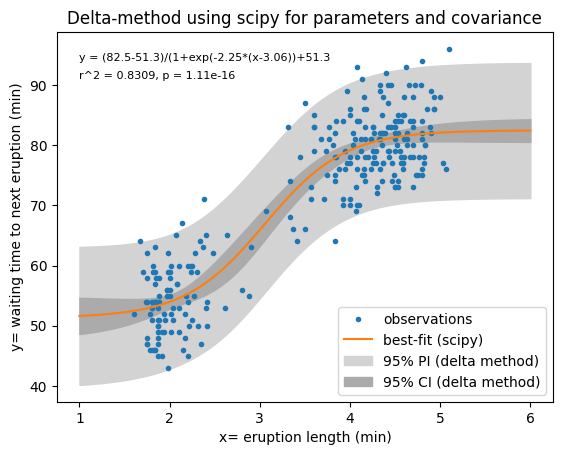

In [16]:
# First we need to define the model function, f(x, …)for scipy.
# It must take the independent variable as the first argument,
# and the parameters to fit as separate remaining arguments.
# Make sure that this function matches the previously defined functions
# "mod" used for Expression model and "f" used for the delta method.
def f_(x, A, gamma, tau, S):
    return (A-S) / ( 1 + exp(-gamma * (x - tau)) ) + S

# Next we will make a numpy array of the initial parameter values to use with scipy.
# Note that the guesses need to be approximately the same order of magnitude as the optimum values
A_init_ = 90
gamma_init_ = 2
tau_init_ = 2
S_init_ = 50
p_init_ = np.array([A_init_, gamma_init_, tau_init_, S_init_])

# Now we are ready to find the optimum best fit paramter array (popt_) and variance-covariance matrix (pcov_) from scipy
# Note that we could also specify min and max bounds for each parameter with the bounds option
popt_, pcov_ = opt.curve_fit(f_, x, y, p0=p_init_, bounds=(-np.inf,np.inf))

# Now we are ready to use the delta_method function to find the prediction interval and confidence interval
# using the scipy estimates of popt_ and pcov_ with the same x_new, f, and alpha that we defined previously
d_ = delta_method(pcov_,popt_,x_new,f,x,y,alpha)

# extract the output values from the delta-method output dictionary
y_new_ = d_['y_new']
lwr_conf_ = d_['lwr_conf']
upr_conf_ = d_['upr_conf']
lwr_pred_ = d_['lwr_pred']
upr_pred_ = d_['upr_pred']
rsquared_ = d_['rsquared']
pvalue_ = d_['pvalue']

# make string values of fit stats and eqn for the plot labels
pstr_ = '%.2e' %pvalue_
rsqstr_ = '%.4f' %rsquared_
b1str_ = '%.1f' %popt_[0]
b2str_ = '%.2f' %popt_[1]
b3str_ = '%.2f' %popt_[2]
b4str_ = '%.1f' %popt_[3]
eqnstr_ = 'y = (' + b1str_ + '-' + b4str_ + ')/(1+exp(-' + b2str_ + '*(x-' + b3str_ + '))+' + b4str_

# plot the results
plt.figure()
plt.plot(x, y, '.', label='observations')
# plt.plot(x_new, y_new, '--k', label='best-fit (lmfit)',linewidth=4)    # lmfit solution of best fit
plt.plot(x_new, y_new_, '-', label='best-fit (scipy)')     # scipy solution of best fit
# 95% prediction limits
plt.fill_between(x_new, d_['lwr_pred'], d_['upr_pred'],color="#d3d3d3", label='95% PI (delta method)')
# 95% confidence limits
plt.fill_between(x_new, d_['lwr_conf'], d_['upr_conf'],color="#ABABAB", label='95% CI (delta method)')
plt.legend(loc='lower right')
plt.title('Delta-method using scipy for parameters and covariance')
plt.xlabel('x= eruption length (min)')
plt.ylabel('y= waiting time to next eruption (min)')
plt.text(1.0, 94, eqnstr_, fontsize = 8)
plt.text(1.0, 91, 'r^2 = '+ rsqstr_ +', p = '+ pstr_, fontsize = 8)
plt.ticklabel_format(style='plain', axis='y')
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))